# Train Part

## Import Libs

In [1]:
import os
import warnings # 避免一些可以忽略的报错
warnings.filterwarnings('ignore')
import random
import gc
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm # 进度条
import time
import math

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler # 学习率调度器
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR

import timm # 预训练神经网络库，可直接调用预训练好的模型
from PIL import Image
import albumentations as A # 数据增强库
from albumentations.pytorch import ToTensorV2

from sklearn.preprocessing import OneHotEncoder # 独热编码

from collections import defaultdict # 记录 loss lr 等相关参数的变化
# 改变 终端颜色 方便观察
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

## CONFIG

In [2]:
is_debug = False

class CONFIG:
    seed = 308
    n_folds = 5
    
    epochs = 2 if not is_debug else 1
    now_cv = 0
    
    is_DataParallel = True
    img_size = [28, 28]
    new_size2train = [32, 32]
    train_batch_size = 256
    valid_batch_size = 512
    test_batch_size = 512
    
    n_classes = 10

    n_workers = os.cpu_count() // 2 # 获取此设备上的 CPU 核心数,使用一半到 DataLoader 的 num_workers
    
    learning_rate = 1e-3
    weight_decay = 1e-6 # 一个参数而已
    scheduler = 'CosineAnnealingWithWarmupLR' # 带热身的优化器
    # T_max : 经过多少 step 降到最低，训练一批 batch 为一个 step，一般训练到最后降到最低 所以可以根据训练数据量动态调整
    T_max = 42000 // n_folds * (n_folds - 1) // train_batch_size * epochs 
    # 33600为train.csv中80%的数据量个数即训练数据量，一轮 (33600 // train_batch_size)个 batch，一共(33600 // train_batch_size) * epochs 个 batch
    min_lr = 1e-6
    
    
    """
    tf_efficientnet_b0.ns_jft_in1k
    tf_efficientnetv2_s.in21k_ft_in1k
    
    convnext_tiny.fb_in22k_ft_in1k_384
    convnext_atto.d2_in1k
    
    tiny_vit_21m_512.dist_in22k_ft_in1k
    # 一般的 vit 模型会限制输入指定大小的图像如 224、384、512等，而 tiny_vit 在拥有优越性能的同时不限制输入大小(推荐使用，但是显存占用会大一点)
    """
    model_names = [
        "tf_efficientnet_b0.ns_jft_in1k",
        "convnext_atto.d2_in1k"
    ]
    ckpt_paths = [
        "/kaggle/input/308-digitrecognizer-base3",
        "/kaggle/input/308-digitrecognizer-base3-convnext-atto"
    ]
    
    pool_name = "" # 最后的全局池化层使用默认的池化层
    timm_pretrained = False # 是否使用预训练模型设置为 True，表示使用预训练模型
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    my_train_csv = "/kaggle/input/my-digit-recognizer-5skf-train-csv/my_digit_recognizer_5skf.csv" # 与 train.csv的唯一区别是多了一列 kfold
    test_csv = "/kaggle/input/digit-recognizer/test.csv"
    img_path = "/kaggle/input/308-digit-recognizer-img/output"
    ckpt_save_path = "/kaggle/working/output"

## Set Random Seed

In [3]:
def set_seed(seed=308):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed(CONFIG.seed) # 固定随机种子，方便结果复现

## Data Progress

In [4]:
train = pd.read_csv(CONFIG.my_train_csv) # 读取训练的 .csv
test = pd.read_csv(CONFIG.test_csv)
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,kfold
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


## Dataset and DataLoader

In [5]:
def transform(img):
    composition = A.Compose([
        A.Resize(CONFIG.new_size2train[0], CONFIG.new_size2train[0]),
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

In [6]:
class MyDataset_train(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx, :] # 从 df 中取出 idx 这一行
        label = row.label
        
        img = row["pixel0": "pixel783"].values
        img = img.reshape(CONFIG.img_size[0], CONFIG.img_size[1], -1)
        img = np.concatenate([img] * 3, axis=-1).astype(np.uint8) # Albumentations 中的部分数据增强操作需要图像为 uint8 数据类型才能执行 
        
        if self.transform != None: # 可进行 totensor 数据增强 等操作
            img = self.transform(img) # ToTensor操作可自动将最后一维的 channel 提前，即 (H, W, C) --> (C, H, W)
        
        return img, label # Dataset 一般一次返回一条 X(特征), y(标签) 这样的形式
    
class MyDataset_test(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx, :] # 从 df 中取出 idx 这一行
        img = row["pixel0":].values
        img = img.reshape(CONFIG.img_size[0], CONFIG.img_size[1], -1).astype(np.uint8)
        img = np.concatenate([img] * 3, axis=-1)
        
        if self.transform != None: # 可进行 totensor 数据增强 等操作
            img = self.transform(img)
        
        return img, str(idx) # 测试集的数据没有 label，我们用它对应的索引代替

In [7]:
def prepare_loaders_train(df, fold=0):
    df_train = df[df["kfold"] != fold]
    df_valid = df[df["kfold"] == fold]
    
    train_datasets = MyDataset_train(df=df_train, transform=transform)
    valid_datasets = MyDataset_train(df=df_valid, transform=transform)
    
    train_loader = DataLoader(train_datasets, batch_size=CONFIG.train_batch_size, num_workers=CONFIG.n_workers, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_datasets, batch_size=CONFIG.valid_batch_size, num_workers=CONFIG.n_workers, shuffle=False, pin_memory=True)
    # valid_loader 一般不行打乱操作 所以 shuffle 为 False
    
    return train_loader, valid_loader

def prepare_loaders_test():
    test_datasets = MyDataset_test(df=test, transform=transform)
    
    test_loader = DataLoader(test_datasets, batch_size=CONFIG.test_batch_size, num_workers=CONFIG.n_workers, shuffle=False, pin_memory=True)
    # 推理过程对数据按顺序执行，不进行打乱操作，shuffle为 False
    
    return test_loader

## Evaluation

In [8]:
def cal_ACC(y_true, y_preds):
    if len(y_true) != len(y_preds):
        raise("len(y_true) != len(y_preds)")
    length = len(y_true)
    acc = (y_true == y_preds).sum() / length
    
    return acc

## Model

In [9]:
class GeMPool(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeMPool, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    
    def gem(self, x, p=3, eps=1e-6):
        return torch.mean(x.clamp(min=eps).pow(p), dim=(-2, -1)).pow(1./p)
    
    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})'

In [10]:
class DigitRecognizerModel(nn.Module):
    def __init__(self, model_name=CONFIG.model_names[0]):
        super(DigitRecognizerModel, self).__init__()
        # 使用 timm.create_model() 创建模型，将模型名称传入 model_name 即可完成创建，pretrained 参数默认为 False，这里我们改为True使用预训练权重
        self.backbone = timm.create_model(model_name=model_name, pretrained=CONFIG.timm_pretrained)
            
        #############################################################################################################################
        # 最后的 head 层
        if "efficientnet" in model_name:
            if CONFIG.pool_name == "GeMPool":
                self.backbone.global_pool = GeMPool() # 修改 最后的全局池化层为 GeMPooling
            in_features = self.backbone.classifier.in_features # 将预训练模型的最后一层的输出参数取出
            self.backbone.classifier = nn.Identity() # nn.Identity() 输入什么就输出什么，这里相当于将模型中的 classifier 层去掉
            
        elif "vit" in model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            
        elif "convnext" in model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        #############################################################################################################################
        
        self.head = nn.Sequential( # 用自定义的 head 层代替原模型中的 classifier 分类层
            nn.Linear(in_features, CONFIG.n_classes)
        )
        
        
    def forward(self, x):
        output = self.backbone(x) # 经过预训练的 模型主干backbone 后得到高级语义信息
        output = self.head(output) # 将高级语义信息传入给分类头进行最后的分类输出
        return output

In [11]:
class ensemblemodel(nn.Module):
    def __init__(self, n_models) -> None:
        super(ensemblemodel, self).__init__()

        self.weights = nn.Parameter(torch.randn(n_models))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, n_model, pred_prob) ---> (batch, pred_prob, n_model)
        Identity = x
        weights = self.softmax(self.weights) # 计算每个模型的权重
        _tmp = Identity * weights # 用每个模型的预测结果 × 其对应的权重
        output = _tmp.sum(dim=2, keepdim=True).flatten(1) # 加权求和再降维 (batch, pred_prob, 1) ---> (batch, pred_prob)
        return output

In [12]:
model = ensemblemodel(n_models=len(CONFIG.model_names)) # 实例化模型
model.to(CONFIG.device)

ensemblemodel(
  (softmax): Softmax(dim=-1)
)

## Load Models to Ensemble

In [13]:
n_models = len(CONFIG.model_names)

total_models = []

for n_model in range(n_models):
    models = []
    
    model_name = CONFIG.model_names[n_model]
    ckpt_path = CONFIG.ckpt_paths[n_model]
    
    paths = sorted(os.listdir(ckpt_path))

    if CONFIG.is_DataParallel:
        device_ids = [0, 1]
        for i in range(CONFIG.n_folds):
            model = DigitRecognizerModel(model_name)
            model = torch.nn.DataParallel(model, device_ids=device_ids)
            model = model.cuda()
            model.load_state_dict(torch.load(os.path.join(ckpt_path, paths[i])))
            print(f"fold : {i} --------- path : {paths[i]}")
            model.eval()
            models.append(model)
    else:
        for i in range(CONFIG.n_folds):
            model = DigitRecognizerModel(model_name)
            model = model.cuda()
            model.load_state_dict(torch.load(os.path.join(ckpt_path, paths[i])))
            print(f"fold : {i} --------- path : {paths[i]}")
            model.eval()
            models.append(model)
    total_models.append(models)
    print(f"######################################### model_{model_name}_{CONFIG.n_folds}_fold load success! #########################################")

fold : 0 --------- path : Fold_0_CV_0.9954_Loss0.1183_epoch10.bin
fold : 1 --------- path : Fold_1_CV_0.9944_Loss0.1183_epoch9.bin
fold : 2 --------- path : Fold_2_CV_0.9939_Loss0.1251_epoch10.bin
fold : 3 --------- path : Fold_3_CV_0.9930_Loss0.1292_epoch8.bin
fold : 4 --------- path : Fold_4_CV_0.9939_Loss0.1206_epoch8.bin
######################################### model_tf_efficientnet_b0.ns_jft_in1k_5_fold load success! #########################################
fold : 0 --------- path : Fold_0_CV_0.9950_Loss0.1101_epoch10.bin
fold : 1 --------- path : Fold_1_CV_0.9943_Loss0.1117_epoch9.bin
fold : 2 --------- path : Fold_2_CV_0.9952_Loss0.1109_epoch7.bin
fold : 3 --------- path : Fold_3_CV_0.9939_Loss0.1139_epoch10.bin
fold : 4 --------- path : Fold_4_CV_0.9948_Loss0.1101_epoch9.bin
######################################### model_convnext_atto.d2_in1k_5_fold load success! #########################################


## Train and Valid Function

In [14]:
criterion = nn.CrossEntropyLoss() # 实例化损失函数 多分类可选 交叉熵损失

In [15]:
def train_one_epoch(model, dl_models, optimizer, scheduler, train_loader, epoch):
    model.train()
    
    y_preds = []
    y_trues = []
    
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(train_loader), total=len(train_loader)) # 进度条
    for step, (images, labels) in bar:
        optimizer.zero_grad()
        
        batch_size = images.size(0)        
        if CONFIG.is_DataParallel: # 使用多卡并行训练
            images = images.cuda().float()
            labels = labels.cuda().long() # 使用标签平滑操作，此处标签为独热编码，所以用 float32数据类型
        else: # 使用单卡训练
            images = images.to(CONFIG.device, dtype=torch.float)
            labels = labels.to(CONFIG.device, dtype=torch.long) # 使用标签平滑操作，此处标签为独热编码，所以用 float32数据类型
            
        # 构建 ensemble 模型的输入
        with torch.no_grad():
            ensemble_input = []
            for dl_model in dl_models:
                dl_pred = dl_model(images) # (batch, 10)
                ensemble_input.append(dl_pred.unsqueeze(1)) # (batch, 10) ---> (batch, 1, 10)
            ensemble_input = torch.cat(ensemble_input, axis=1)
        
        outputs = model(ensemble_input)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        y_preds.append(F.softmax(outputs).argmax(1).detach().cpu().numpy())
        y_trues.append(labels.detach().cpu().numpy())
        _y_preds = np.concatenate(y_preds)
        _y_trues = np.concatenate(y_trues)

        train_cv = cal_ACC(_y_trues, _y_preds)

        running_loss += (loss.item() * batch_size)

        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        # 设置让进度条显示的数据
        bar.set_postfix(Epoch=epoch,
                        Train_Loss=epoch_loss,
                        Train_ACC=train_cv,
                        LR=optimizer.param_groups[0]['lr'])
 
    return epoch_loss, train_cv

In [16]:
@torch.inference_mode()
def valid_one_epoch(model, dl_models, valid_loader, epoch):
    model.eval()
    
    y_preds = []
    y_trues = []
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            
            if CONFIG.is_DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().long()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.long)
                
            # 构建 ensemble 模型的输入
            ensemble_input = []
            for dl_model in dl_models:
                dl_pred = dl_model(images) # (batch, 10)
                ensemble_input.append(dl_pred.unsqueeze(1)) # (batch, 10) ---> (batch, 1, 10)
            ensemble_input = torch.cat(ensemble_input, axis=1)

            outputs = model(ensemble_input)
            loss = criterion(outputs, labels)

            y_preds.append(F.softmax(outputs).argmax(1).detach().cpu().numpy())
            y_trues.append(labels.detach().cpu().numpy())
            _y_preds = np.concatenate(y_preds)
            _y_trues = np.concatenate(y_trues)
            
            valid_cv = cal_ACC(_y_trues, _y_preds)
        
            running_loss += (loss.item() * batch_size)

            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size

            bar.set_postfix(Epoch=epoch,
                            Valid_Loss=epoch_loss,
                            Valid_ACC=valid_cv,
                            LR=optimizer.param_groups[0]['lr'])

    return epoch_loss, valid_cv

In [17]:
def run_training(fold, model, dl_models, optimizer, scheduler, train_loader, valid_loader, num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {} x {}\n".format(torch.cuda.get_device_name(), torch.cuda.device_count()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # 用于 存储最好的 cv 的模型权重
    best_epoch_cv = now_cv
    best_model_path = None # # 用于 存储最好的 cv 的模型权重的路径
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        gc.collect() # 立即回收，清除缓存中的垃圾
        train_epoch_loss, train_epoch_cv = train_one_epoch(model, dl_models, optimizer, scheduler, train_loader, epoch)
        valid_epoch_loss, valid_epoch_cv = valid_one_epoch(model, dl_models, valid_loader, epoch)
        print(f"epoch: {epoch}, LOSS = {valid_epoch_loss}, CV(Acc) = {valid_epoch_cv}")
        
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Train CV(Acc)'].append(train_epoch_cv)
        history['Valid CV(Acc)'].append(valid_epoch_cv)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # deep copy the model
        if valid_epoch_cv >= best_epoch_cv:
            print(f"{b_}epoch: {epoch}, Validation CV(Acc) Improved ({best_epoch_cv} ---> {valid_epoch_cv}))")
            best_epoch_cv = valid_epoch_cv
            best_model_wts = copy.deepcopy(model.state_dict())
            if os.path.exists(CONFIG.ckpt_save_path) is False: # 如果该路径不存在，创建相关路径
                os.makedirs(CONFIG.ckpt_save_path)
                
            PATH = "{}/Fold_{}_CV_{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(CONFIG.ckpt_save_path, fold, best_epoch_cv, valid_epoch_loss, epoch)
            best_model_path = PATH
            torch.save(model.state_dict(), PATH) # 只保存模型的权重参数到指定路径
            print(f"Model Saved{sr_}")
            
        print()
    
    # 计算训练总消耗时间
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best CV(Acc): {:.4f}".format(best_epoch_cv))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history, best_model_path

## Optimizer

In [18]:
class CosineAnnealingWithWarmupLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, warmup_epochs=10, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        self.warmup_epochs = warmup_epochs
        self.cosine_epochs = T_max - warmup_epochs
        super(CosineAnnealingWithWarmupLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Linear warmup
            return [(base_lr * (self.last_epoch + 1) / self.warmup_epochs) for base_lr in self.base_lrs]
        else:
            # Cosine annealing
            cosine_epoch = self.last_epoch - self.warmup_epochs
            return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * cosine_epoch / self.cosine_epochs)) / 2 for base_lr in self.base_lrs]

In [19]:
# lr scheduler
def fetch_scheduler(optimizer, T_max, min_lr):
    if CONFIG.scheduler == 'CosineAnnealingLR': # 学习率根据 cos 函数特性下降，可以观察最后 logs 画出来的图像中 学习率的变化
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWithWarmupLR':
        scheduler = CosineAnnealingWithWarmupLR(optimizer, T_max=T_max, eta_min=min_lr, 
                                                warmup_epochs=T_max//CONFIG.epochs)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

In [20]:
# 指定优化器为 AdamW
# optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
#                              weight_decay=CONFIG.weight_decay)
# scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max, min_lr=CONFIG.min_lr)

## Start Training

In [21]:
oof = []
true = []
historys = []

for fold in range(CONFIG.n_folds):
    print(f"================================ Fold {fold} start training ================================")
    del model # 将上一个fold的模型删除，重新初始化模型训练当前的fold
    torch.cuda.empty_cache()
    model = ensemblemodel(n_models=len(CONFIG.model_names))
    if CONFIG.is_DataParallel:
        device_ids = [0, 1] # 一共使用两张卡，编号为 0和1
        model = torch.nn.DataParallel(model, device_ids=device_ids) # 将模型并行化到2张卡上
        model = model.cuda()
    else:
        model = model.to(CONFIG.device)
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
                                  weight_decay=CONFIG.weight_decay)
    scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max, min_lr=CONFIG.min_lr)
    
    dl_models = []
    for n_model in range(len(CONFIG.model_names)):
        dl_models.append(total_models[n_model][fold])
    
    train_loader, valid_loader = prepare_loaders_train(train, fold)
    model, history, best_model_path = run_training(fold, model, dl_models, optimizer, scheduler, train_loader, valid_loader, 
                                                   num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv)
    historys.append(history)
    
    # 这一个fold的训练完成后，对这个fold的验证集进行推理，用于计算后面的 oof折外预测
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            if CONFIG.is_DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.float)
                
            # 构建 ensemble 模型的输入
            ensemble_input = []
            for dl_model in dl_models:
                dl_pred = dl_model(images) # (batch, 10)
                ensemble_input.append(dl_pred.unsqueeze(1)) # (batch, 10) ---> (batch, 1, 10)
            ensemble_input = torch.cat(ensemble_input, axis=1)

            outputs = model(ensemble_input)
            outputs = F.softmax(outputs).argmax(1)
            
            oof.append(outputs.flatten().detach().cpu().numpy())
            true.append(labels.detach().cpu().numpy())
        print() # 换行

================================ Fold 0 start training ================================
[INFO] Using GPU: Tesla T4 x 2



100%|██████████| 17/17 [00:05<00:00,  3.27it/s, Epoch=1, LR=0.001, Valid_ACC=0.996, Valid_Loss=0.115]


epoch: 1, LOSS = 0.11485563482557025, CV(Acc) = 0.9961904761904762
epoch: 1, Validation CV(Acc) Improved (0 ---> 0.9961904761904762))
Model Saved



100%|██████████| 17/17 [00:05<00:00,  3.06it/s, Epoch=2, LR=1.57e-6, Valid_ACC=0.996, Valid_Loss=0.115]

epoch: 2, LOSS = 0.11450958085911614, CV(Acc) = 0.9961904761904762
epoch: 2, Validation CV(Acc) Improved (0.9961904761904762 ---> 0.9961904761904762))
Model Saved

Training complete in 0h 1m 3s
Best CV(Acc): 0.9962



100%|██████████| 17/17 [00:05<00:00,  3.26it/s]



================================ Fold 1 start training ================================
[INFO] Using GPU: Tesla T4 x 2



100%|██████████| 17/17 [00:05<00:00,  3.07it/s, Epoch=1, LR=0.001, Valid_ACC=0.995, Valid_Loss=0.117]


epoch: 1, LOSS = 0.11665443918534688, CV(Acc) = 0.9947619047619047
epoch: 1, Validation CV(Acc) Improved (0 ---> 0.9947619047619047))
Model Saved



100%|██████████| 17/17 [00:05<00:00,  3.12it/s, Epoch=2, LR=1.57e-6, Valid_ACC=0.995, Valid_Loss=0.116]

epoch: 2, LOSS = 0.116457387365046, CV(Acc) = 0.9947619047619047
epoch: 2, Validation CV(Acc) Improved (0.9947619047619047 ---> 0.9947619047619047))
Model Saved

Training complete in 0h 1m 2s
Best CV(Acc): 0.9948



100%|██████████| 17/17 [00:05<00:00,  3.25it/s]



================================ Fold 2 start training ================================
[INFO] Using GPU: Tesla T4 x 2



100%|██████████| 17/17 [00:05<00:00,  3.03it/s, Epoch=1, LR=0.001, Valid_ACC=0.996, Valid_Loss=0.113]


epoch: 1, LOSS = 0.11279366327183588, CV(Acc) = 0.9957142857142857
epoch: 1, Validation CV(Acc) Improved (0 ---> 0.9957142857142857))
Model Saved



100%|██████████| 17/17 [00:05<00:00,  3.08it/s, Epoch=2, LR=1.57e-6, Valid_ACC=0.995, Valid_Loss=0.113]

epoch: 2, LOSS = 0.11254134128491083, CV(Acc) = 0.9953571428571428

Training complete in 0h 1m 2s
Best CV(Acc): 0.9957



100%|██████████| 17/17 [00:05<00:00,  3.23it/s]



================================ Fold 3 start training ================================
[INFO] Using GPU: Tesla T4 x 2



100%|██████████| 17/17 [00:05<00:00,  3.05it/s, Epoch=1, LR=0.001, Valid_ACC=0.994, Valid_Loss=0.117]


epoch: 1, LOSS = 0.11715219171274276, CV(Acc) = 0.9941666666666666
epoch: 1, Validation CV(Acc) Improved (0 ---> 0.9941666666666666))
Model Saved



100%|██████████| 17/17 [00:05<00:00,  3.09it/s, Epoch=2, LR=1.57e-6, Valid_ACC=0.994, Valid_Loss=0.117]

epoch: 2, LOSS = 0.11677759993643988, CV(Acc) = 0.9940476190476191

Training complete in 0h 1m 2s
Best CV(Acc): 0.9942



100%|██████████| 17/17 [00:05<00:00,  3.29it/s]



================================ Fold 4 start training ================================
[INFO] Using GPU: Tesla T4 x 2



100%|██████████| 17/17 [00:05<00:00,  3.08it/s, Epoch=1, LR=0.001, Valid_ACC=0.995, Valid_Loss=0.11]


epoch: 1, LOSS = 0.11005422949790955, CV(Acc) = 0.9946428571428572
epoch: 1, Validation CV(Acc) Improved (0 ---> 0.9946428571428572))
Model Saved



100%|██████████| 17/17 [00:05<00:00,  3.07it/s, Epoch=2, LR=1.57e-6, Valid_ACC=0.995, Valid_Loss=0.11]

epoch: 2, LOSS = 0.11003214081128439, CV(Acc) = 0.9946428571428572
epoch: 2, Validation CV(Acc) Improved (0.9946428571428572 ---> 0.9946428571428572))
Model Saved

Training complete in 0h 1m 3s
Best CV(Acc): 0.9946



100%|██████████| 17/17 [00:05<00:00,  3.22it/s]

## Local CV

In [22]:
oof = np.concatenate(oof)
true = np.concatenate(true)

In [23]:
local_cv = cal_ACC(true, oof)
print("Local CV : ", local_cv)

Local CV :  0.9950952380952381


## Logs

In [24]:
fold = 0
history = historys[fold]

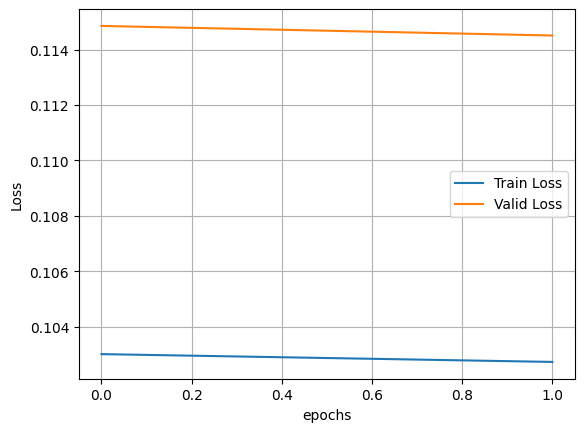

In [25]:
plt.plot( range(len(history["Train Loss"])), history["Train Loss"], label="Train Loss")
plt.plot( range(len(history["Valid Loss"])), history["Valid Loss"], label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

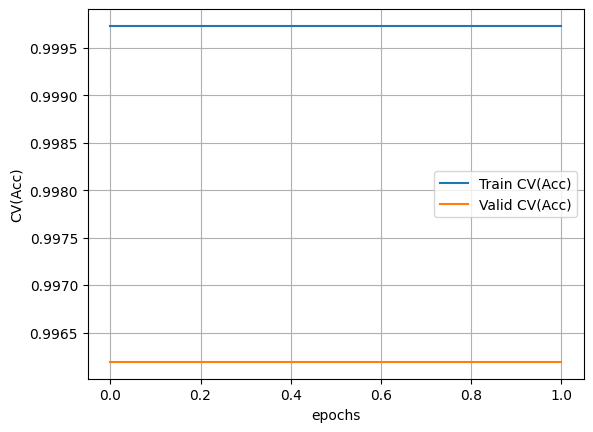

In [26]:
plt.plot( range(len(history["Train CV(Acc)"])), history["Train CV(Acc)"], label="Train CV(Acc)")
plt.plot( range(len(history["Valid CV(Acc)"])), history["Valid CV(Acc)"], label="Valid CV(Acc)")
plt.xlabel("epochs")
plt.ylabel("CV(Acc)")
plt.grid()
plt.legend()
plt.show()

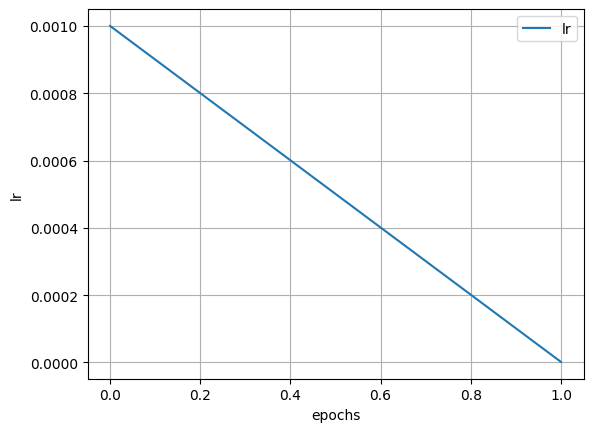

In [27]:
plt.plot( range(len(history["lr"])), history["lr"], label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()

# Infer Part

In [28]:
ensemblemodel_path = []

all_paths = os.listdir(CONFIG.ckpt_save_path)
for fold in range(CONFIG.n_folds):
    fold_paths = []
    for path in all_paths:
        if f"Fold_{fold}" in path:
            fold_paths.append(path)
    fold_paths = sorted(fold_paths, key=lambda x: float(x.split("_")[3]))
    ensemblemodel_path.append(fold_paths[-1])
print(ensemblemodel_path)
    
ensemble_models = []

if CONFIG.is_DataParallel:
    device_ids = [0, 1]
    for i in range(CONFIG.n_folds):
        model = ensemblemodel(n_models=len(CONFIG.model_names))
        model = torch.nn.DataParallel(model, device_ids=device_ids)
        model = model.cuda()
        model.load_state_dict(torch.load(os.path.join(CONFIG.ckpt_save_path, ensemblemodel_path[i])))
        print(f"fold : {i} --------- path : {paths[i]}")
        model.eval()
        ensemble_models.append(model)
else:
    for i in range(CONFIG.n_folds):
        model = ensemblemodel(n_models=len(CONFIG.model_names))
        model = model.cuda()
        model.load_state_dict(torch.load(os.path.join(CONFIG.ckpt_save_path, ensemblemodel_path[i])))
        print(f"fold : {i} --------- path : {paths[i]}")
        model.eval()
        ensemble_models.append(model)

['Fold_0_CV_0.9962_Loss0.1149_epoch1.bin', 'Fold_1_CV_0.9948_Loss0.1165_epoch2.bin', 'Fold_2_CV_0.9957_Loss0.1128_epoch1.bin', 'Fold_3_CV_0.9942_Loss0.1172_epoch1.bin', 'Fold_4_CV_0.9946_Loss0.1101_epoch1.bin']
fold : 0 --------- path : Fold_0_CV_0.9950_Loss0.1101_epoch10.bin
fold : 1 --------- path : Fold_1_CV_0.9943_Loss0.1117_epoch9.bin
fold : 2 --------- path : Fold_2_CV_0.9952_Loss0.1109_epoch7.bin
fold : 3 --------- path : Fold_3_CV_0.9939_Loss0.1139_epoch10.bin
fold : 4 --------- path : Fold_4_CV_0.9948_Loss0.1101_epoch9.bin


## Infer Function

In [29]:
def Infer(model, dl_models, test_loader):
    model.eval()
    
    y_preds = []
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for step, (images, img_id) in bar:

            if CONFIG.is_DataParallel:
                images = images.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
            
            # 构建 ensemble 模型的输入
            ensemble_input = []
            for dl_model in dl_models:
                dl_pred = dl_model(images) # (batch, 10)
                ensemble_input.append(dl_pred.unsqueeze(1)) # (batch, 10) ---> (batch, 1, 10)
            ensemble_input = torch.cat(ensemble_input, axis=1)

            outputs = model(ensemble_input)

            y_preds.append(outputs.detach().cpu().numpy())
            
    y_preds = np.concatenate(y_preds) # 因为最后要做每个fold 训练出来的模型的结果的融合，所以这里返回模型预测的每一类的概率值，不经过softmax，也不取 argmax

    return y_preds

## Start Infer

In [30]:
# test preds
total_test_pred = []

test_loader = prepare_loaders_test()

for fold in range(0, CONFIG.n_folds):
    dl_models = []
    for n_model in range(len(CONFIG.model_names)):
        dl_models.append(total_models[n_model][fold])
        
    preds = Infer(ensemble_models[fold], dl_models, test_loader)
    total_test_pred.append(preds)
    
total_test_pred = np.mean(total_test_pred, axis=0) # 将每一个 fold的模型输出的结果进行均值融合
total_test_pred = F.softmax(torch.from_numpy(total_test_pred)).numpy() # 对融合的结果进行 softmax转换为概率值
y_preds = total_test_pred.argmax(1) # 取概率值最高的一类作为预测值

100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


## Make Submission

In [31]:
sub = pd.DataFrame()
sub["ImageId"] = test.index + 1
sub["Label"] = y_preds
sub

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [32]:
sub.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
